In [1]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
#!pip install pip --upgrade

In [84]:
#!pip install nltk sklearn wordcloud pymorphy2 stop_words

In [85]:
#!pip install pandas numpy matplotlib seaborn sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
import seaborn as sns
from scipy.sparse import *
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import json

%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

**Загружаем данные**

In [3]:
news = []
with open('corpus.json', 'r', encoding="utf-8") as file:
    text = file.read()
    dct = json.loads(text)
data = pd.DataFrame(dct['catalog'])
data.head()

,article_id,category,title,text,tags
0,https://www.nn.ru/text/auto/2022/01/12/70369148/,auto,Кризис ОСАГО залатали рублем. Полисы резко под...,ОСАГО сильно прибавило для неблагополучных вод...,"[ОСАГО, автозакон, страховка]"
1,https://www.nn.ru/text/auto/2022/01/11/70366607/,auto,Я пропустил техосмотр в 2021 году. Оштрафуют л...,Обязательный техосмотр для частных машин отмен...,"[автозакон, техосмотр, автоликбез]"
2,https://www.nn.ru/text/auto/2022/01/08/70343681/,auto,Цены отмороженные: как кризис автомобильных пр...,Автомобили снова стали для большинства из нас ...,"[автопром, авторынок, цены на авто]"
3,https://www.nn.ru/text/auto/2022/01/07/70350704/,auto,"Новые Vesta и Logan, пятый Sportage и много «к...",Главная премьера начала года — новый KIA Sport...,"[автопром, авторынок, цены на авто]"
4,https://www.nn.ru/text/auto/2022/01/04/70343603/,auto,Бензин по 50 рублей — это лишь начало. Что жде...,Топливо дорожало весь прошлый год и установило...,"[АЗС, бензин, топливо, цены на топливо]"


## Предобработка собранных новостей

**Тексты**

In [4]:
data.text

0       ОСАГО сильно прибавило для неблагополучных вод...
1       Обязательный техосмотр для частных машин отмен...
2       Автомобили снова стали для большинства из нас ...
3       Главная премьера начала года — новый KIA Sport...
4       Топливо дорожало весь прошлый год и установило...
                              ...                        
4094    Поделиться   Предсказать массовые сокращения с...
4095    Поделиться   NN.RU: Трудоустройство инвалидов ...
4096    Поделиться   Эксперты МОТ обосновали предложен...
4097    commons.wikimedia.org   Поделиться   \- В Росс...
4098    Сбербанк   Поделиться   Сбербанк предлагает то...
Name: text, Length: 4099, dtype: object

**Категории**

In [5]:
data.category.unique()

array(['auto', 'gorod', 'health', 'job'], dtype=object)

In [6]:
labels = {'auto':0, 'gorod':1, 'health':2, 'job':3}

In [7]:
for cat in labels.keys():
    print(f'{data[data.category == cat].count()[0]} новостей в категории {cat}')

1036 новостей в категории auto
1024 новостей в категории gorod
1032 новостей в категории health
1007 новостей в категории job


Мы имеем всего 4099 новостей в 4-х категориях. Каждая категория содержит около 1000 новостей.

In [8]:
corpus, texts = [], []
categories = data.category.to_list()

for message in log_progress(data.text):
    corpus.append(message)
    texts.append(message)
#     break

# print(len(corpus), len(texts))

**Посмотрим на одну новость из корпуса**

In [9]:
corpus[1000]

'На крытой парковке магазина «О′кей» на Комсомольской площади нижегородка Оля Андрушенко запечатлела иномарку, которая перегородила половину выхода.   Поделиться   Водитель Toyota на совершенно пустой парковке у торгового центра оставил свой автомобиль на месте для инвалидов. Автор фотографии подписал снимок кратко: «Но алени...».      Поделиться   Борис Реутов сделал прекрасный утренний кадр: в лучах восхода два одинаковых автомобиля Opel перекрыли съезд с бордюра. Настоящий квест для мам с колясками. Как говорится: «¡No pasaran!»   Поделиться   Традиционный кадр из центра Сормова: автомобилист встал на пешеходном переходе и перекрыл съезд с бордюра.   Поделиться   Большой дорожный просвет позволяет беспрепятственно парковаться на газоне.   — Понтов ровно на старый Lexus... — подписал свое фото Александр Демин.   Поделиться   На каждый съезд с бордюра найдется свой автолюбитель! Очередного автохама сфотографировал Сергей Гаврилюк.   Поделиться   — Молодец. Очень хорошо и грамотно прип

Можно заметить, что в тексте несколько раз встречается надпись *"Поделиться"*. Исправим это.

In [10]:
corpus = np.asarray([doc.replace('Поделиться', '') for doc in corpus])
print(len(corpus))

4099


**Уберем ссылки:**

In [11]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in corpus]
print(len(corpus))

4099


**Уберем лишние пробелы:**

In [12]:
corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'')    for doc in corpus])
print(len(corpus))

4099


**Уберем другие лишние символы:**

In [13]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [16]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

4099


In [17]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

4099


In [18]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

4099


In [19]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

4099


In [20]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

4099


In [21]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

4099


In [22]:
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
print(len(corpus))

4099


In [23]:
new_texts = []
new_corpus = []
new_categories = []

for corpus_doc, text, cat in zip(corpus, texts, categories):
    if (len(corpus_doc) == 0):
        continue
    new_corpus.append(corpus_doc)
    new_texts.append(text)
    new_categories.append(cat)

In [24]:
corpus = new_corpus
texts = new_texts
categories = new_categories

После предобработки и приведения к нижнему регистру наша новость выглядит вот так.

In [25]:
corpus[1000]

'на крытой парковке магазина о′кей на комсомольской площади нижегородка оля андрушенко запечатлела иномарку которая перегородила половину выхода водитель toyota на совершенно пустой парковке у торгового центра оставил свой автомобиль на месте для инвалидов автор фотографии подписал снимок кратко но алени борис реутов сделал прекрасный утренний кадр в лучах восхода два одинаковых автомобиля opel перекрыли съезд с бордюра настоящий квест для мам с колясками как говорится ¡no pasaran традиционный кадр из центра сормова автомобилист встал на пешеходном переходе и перекрыл съезд с бордюра большой дорожный просвет позволяет беспрепятственно парковаться на газоне понтов ровно на старый lexus подписал свое фото александр демин на каждый съезд с бордюра найдется свой автолюбитель очередного автохама сфотографировал сергей гаврилюк молодец очень хорошо и грамотно припарковался на улице минина подписала снимок анастасия прямо перед входом в зеленый парус перекрыл вход двери не открыть притаившийс

Удалим из текстов стоп-слова.

In [26]:
morph = pymorphy2.MorphAnalyzer()

In [27]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens), len(texts))

4095 4095


In [28]:
inds_to_drop

[]

Текстов, состоящих полностью из стоп-слов, нет.

**Стемминг**

Приведем слова во всех текстах к нормальной форме с помощью стемминга.

In [28]:
stemmer = RussianStemmer()

In [29]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

4095


До

In [142]:
corpus_tokens[100][:5]

['дтп', 'произошло', 'челябинске', 'надежда', 'погибла']

После

In [143]:
corpus_tokens_stem[100][:5]

['дтп', 'произошл', 'челябинск', 'надежд', 'погибл']

In [32]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

4095 4095


C:\Users\antid\AppData\Local\Temp\ipykernel_14236\3369661828.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus_tokens_stem = np.asarray(corpus_tokens_stem)


In [33]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

4095


In [34]:
diffs[:5]

array([551, 541, 873, 622, 524])

In [35]:
sns.set(style="darkgrid")

**Распределение длин текстов**

<AxesSubplot:ylabel='Count'>

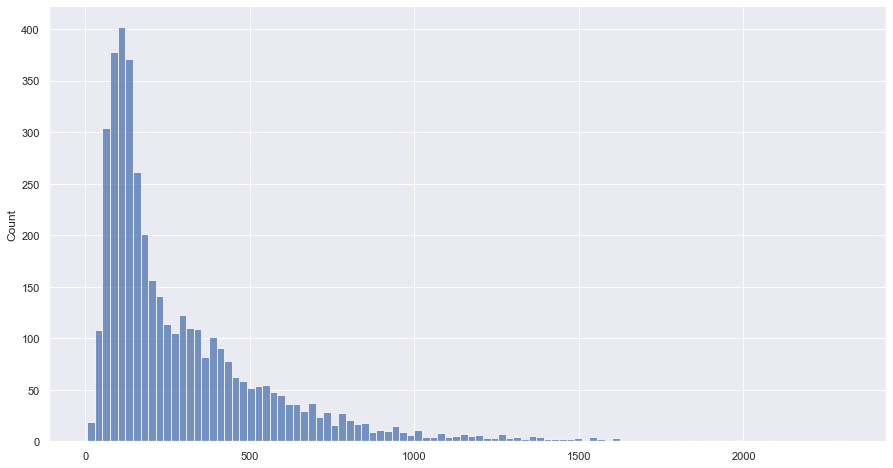

In [36]:
plt.figure(figsize=(15, 8))
sns.histplot(diffs, bins=100)

Как видно из графика основная доля текстов имеет длину в пределах от 0 до 700 токенов.

In [39]:
stat = {}
tmp_corp, tmp_texts, tmp_categories = [], [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(texts[i])
        tmp_categories.append(categories[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
categories = tmp_categories
print(len(corpus_tokens_stem), len(texts), len(categories))

4058 4058 4058


In [40]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)
categories = np.asarray(categories)

print(len(corpus_tokens_stem), len(texts), len(categories))

4058 4058 4058


C:\Users\antid\AppData\Local\Temp\ipykernel_14236\3516711116.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus_tokens_stem = np.asarray(corpus_tokens_stem)


In [42]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

4058


**Распределение длин текстов после исключения одинаковых наборов токенов**

<AxesSubplot:ylabel='Count'>

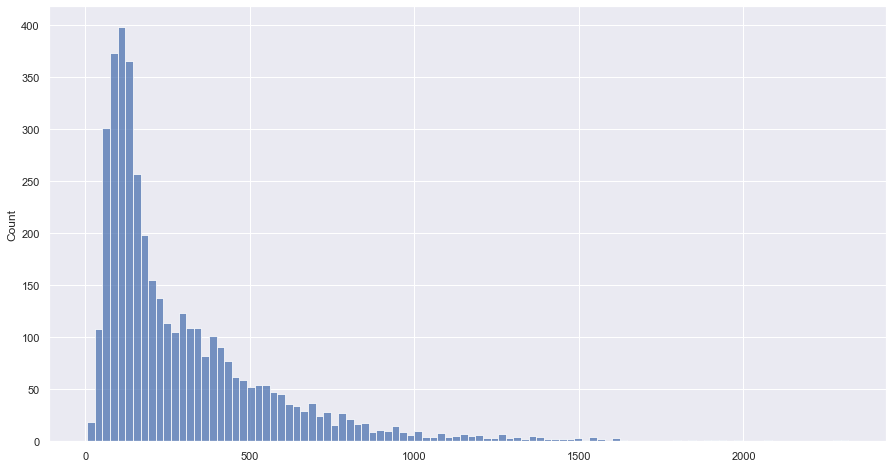

In [43]:
plt.figure(figsize=(15, 8))
sns.histplot(diffs, bins=100)

Отберем тексты длиной не менее 10 токенов.

In [45]:
corp4learning = corpus_tokens_stem[diffs >= 10]
texts4learning = texts[diffs >= 10]
categories4learning = categories[diffs >= 10]

In [49]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

**Словарь**

In [144]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(f'Количество токенов в словаре: {len(vocab)}')

Количество токенов в словаре: 33729


In [145]:
print('Первые 10 слов в словаре:')
vocab[:10]

Первые 10 слов в словаре:


['абака',
 'абакан',
 'абакум',
 'абакумов',
 'аббревиатур',
 'абвер',
 'абдоминальн',
 'абдулкерим',
 'аберрац',
 'абзац']

Таким образом, мы получили датасет из предобработанных текстов, каждый из которых соответсвует классу (категории).

In [95]:
X = np.asarray([' '.join(words) for words in corp4learning])
y = np.asarray([labels[cat] for cat in categories4learning])

Воспользуемся такой техникой извлечения признаков, как мешок слов. У этого метода есть проблема: слова с наибольшей частотой имеют, соответственно, наибольшую оценку. Она решается с помощью TF-IDF.

In [97]:
vectorizer = CountVectorizer(max_features=5000, min_df=5, max_df=0.7)
tfidfconverter = TfidfTransformer()

In [98]:
X_trans = vectorizer.fit_transform(X).toarray()
X_trans = tfidfconverter.fit_transform(X_trans).toarray()

In [99]:
X = X_trans

Разобьем датасет на тренировочную и тестовую выборки.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Модели классификации

Рассмотрим 6 моделей классификации из библиотеки *sklearn*
 - KNN
 - Logistic Regression
 - Decision Tree Classifier
 - Random Forest Classifier
 - AdaBoost Classifier
 - HistGradientBoosting Classifier

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score,precision_score, f1_score

In [95]:
def print_report(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred,average='macro'))
    print("F1:", f1_score(y_test, y_pred, average='macro'))
    plt.title('Confusion matrix')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
    print(classification_report(y_test, y_pred, target_names=list(labels.keys())))

In [96]:
def compute_metrics(model_name, y_test, y_pred):
    metrics = {}
    metrics['model'] = model_name
    metrics['accuracy_score'] = accuracy_score(y_test, y_pred)
    metrics['recall_score'] = recall_score(y_test, y_pred, average='macro')
    metrics['precision_score'] = precision_score(y_test, y_pred,average='macro')
    metrics['f1_score'] = f1_score(y_test, y_pred,average='macro')
    return metrics.copy()

Для подбора оптимальных параметров классификаторов будем использовать Grid Search. Будем искать такие оптимальные параметры, при которых F1-score будет максимальным.

**KNN**

In [107]:
decision_param = {
    "n_neighbors": range(5,15),
    'weights': ['distance', 'uniform']
}

grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=decision_param, 
                    cv=5, verbose=1, scoring='f1_macro')

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [108]:
knn_params = grid.best_params_
knn_params

{'n_neighbors': 10, 'weights': 'distance'}

Accuracy: 0.9235511713933415
Recall: 0.9246309436044711
Precision: 0.9236813610206343
F1: 0.9237846122990394
              precision    recall  f1-score   support

        auto       0.94      0.97      0.95       186
       gorod       0.89      0.85      0.87       207
      health       0.91      0.96      0.93       208
         job       0.95      0.92      0.94       210

    accuracy                           0.92       811
   macro avg       0.92      0.92      0.92       811
weighted avg       0.92      0.92      0.92       811



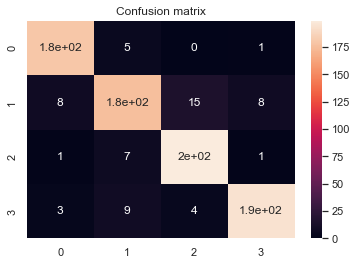

In [109]:
print_report(y_test, y_pred)

- Данная модель довольно хорошо предсказывает классы auto, health и job.
- KNN лучше всего предсказывает класс auto.
- Метрики для категории gorod самые низкие.

In [110]:
KNN_metrics = compute_metrics('KNeighborsClassifier', y_test, y_pred)
KNN_metrics

{'model': 'KNeighborsClassifier',
 'accuracy_score': 0.9235511713933415,
 'recall_score': 0.9246309436044711,
 'precision_score': 0.9236813610206343,
 'f1_score': 0.9237846122990394}

**Logistic Regression**

In [111]:
decision_param = {
    "solver": ['lbfgs','sag', 'saga', 'liblinear'],
}

grid = GridSearchCV(estimator=LogisticRegression(), param_grid=decision_param, 
                    cv=5, verbose=3, scoring='f1_macro')

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ......................solver=lbfgs;, score=0.938 total time=   3.1s
[CV 2/5] END ......................solver=lbfgs;, score=0.909 total time=   3.0s
[CV 3/5] END ......................solver=lbfgs;, score=0.923 total time=   3.1s
[CV 4/5] END ......................solver=lbfgs;, score=0.922 total time=   3.1s
[CV 5/5] END ......................solver=lbfgs;, score=0.915 total time=   2.9s
[CV 1/5] END ........................solver=sag;, score=0.938 total time=   6.0s
[CV 2/5] END ........................solver=sag;, score=0.909 total time=   6.1s
[CV 3/5] END ........................solver=sag;, score=0.923 total time=   6.4s
[CV 4/5] END ........................solver=sag;, score=0.921 total time=   5.5s
[CV 5/5] END ........................solver=sag;, score=0.915 total time=   5.6s
[CV 1/5] END .......................solver=saga;, score=0.938 total time=   4.5s
[CV 2/5] END .......................solver=saga;,

In [112]:
logreg_params = grid.best_params_
logreg_params

{'solver': 'lbfgs'}

Accuracy: 0.9408138101109741
Recall: 0.9412934735515381
Precision: 0.9412723474607846
F1: 0.9412106582096732
              precision    recall  f1-score   support

        auto       0.96      0.96      0.96       186
       gorod       0.90      0.89      0.90       207
      health       0.93      0.96      0.95       208
         job       0.97      0.95      0.96       210

    accuracy                           0.94       811
   macro avg       0.94      0.94      0.94       811
weighted avg       0.94      0.94      0.94       811



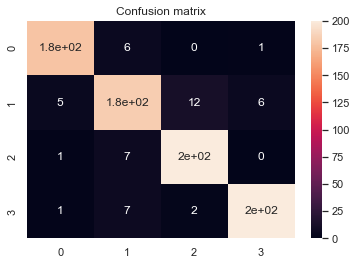

In [113]:
print_report(y_test, y_pred)

- Результаты логистической регрессии заметно лучше по сравнению с предыдущей моделью.
- Класс gorod также плохо предсказывается.

In [114]:
LogReg_metrics = compute_metrics('LogisticRegression',y_test, y_pred)
LogReg_metrics

{'model': 'LogisticRegression',
 'accuracy_score': 0.9408138101109741,
 'recall_score': 0.9412934735515381,
 'precision_score': 0.9412723474607846,
 'f1_score': 0.9412106582096732}

**Decision Tree**

In [115]:
decision_param = {
    "criterion": ['gini', 'entropy'],
    "min_samples_leaf": range(8, 13, 2),
    "max_depth": range(5, 10),
    "min_samples_split": range(2, 8, 2),
}

grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=decision_param, 
                    cv=5, verbose=1, scoring='f1_macro')

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


In [116]:
tree_params = grid.best_params_
tree_params

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 8,
 'min_samples_split': 6}

Accuracy: 0.8471023427866831
Recall: 0.8472464003582517
Precision: 0.8523355924706693
F1: 0.8485361577218469
              precision    recall  f1-score   support

        auto       0.86      0.85      0.86       186
       gorod       0.74      0.85      0.79       207
      health       0.88      0.82      0.85       208
         job       0.92      0.87      0.90       210

    accuracy                           0.85       811
   macro avg       0.85      0.85      0.85       811
weighted avg       0.85      0.85      0.85       811



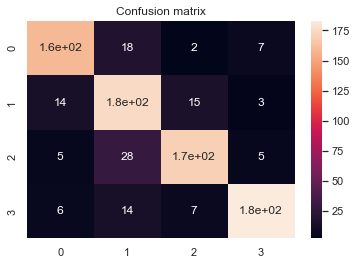

In [117]:
print_report(y_test, y_pred)

- Дерево решений в целом показало худшие результаты.
- Модель выдает много ложных предсказаний для категории gorod, у нее низкий precision. Она присваивает статьям из других категорий класс gorod.

In [118]:
DesicionTree_metrics = compute_metrics('DecisionTree', y_test, y_pred)
DesicionTree_metrics

{'model': 'DecisionTree',
 'accuracy_score': 0.8471023427866831,
 'recall_score': 0.8472464003582517,
 'precision_score': 0.8523355924706693,
 'f1_score': 0.8485361577218469}

**Random forest**

In [119]:
decision_param = {
    "criterion": ['gini', 'entropy'],
    "n_estimators": [50, 100]
}

grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=decision_param, 
                    cv=5, verbose=3, scoring='f1_macro')

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...criterion=gini, n_estimators=50;, score=0.930 total time=   1.0s
[CV 2/5] END ...criterion=gini, n_estimators=50;, score=0.919 total time=   1.0s
[CV 3/5] END ...criterion=gini, n_estimators=50;, score=0.919 total time=   1.0s
[CV 4/5] END ...criterion=gini, n_estimators=50;, score=0.910 total time=   1.0s
[CV 5/5] END ...criterion=gini, n_estimators=50;, score=0.902 total time=   1.0s
[CV 1/5] END ..criterion=gini, n_estimators=100;, score=0.935 total time=   2.2s
[CV 2/5] END ..criterion=gini, n_estimators=100;, score=0.917 total time=   2.3s
[CV 3/5] END ..criterion=gini, n_estimators=100;, score=0.919 total time=   2.2s
[CV 4/5] END ..criterion=gini, n_estimators=100;, score=0.907 total time=   2.1s
[CV 5/5] END ..criterion=gini, n_estimators=100;, score=0.912 total time=   2.2s
[CV 1/5] END criterion=entropy, n_estimators=50;, score=0.930 total time=   1.1s
[CV 2/5] END criterion=entropy, n_estimators=50;,

In [120]:
forest_params = grid.best_params_
forest_params

{'criterion': 'entropy', 'n_estimators': 100}

Accuracy: 0.9395807644882861
Recall: 0.9402894440762604
Precision: 0.93948992137523
F1: 0.9393237121524952
              precision    recall  f1-score   support

        auto       0.94      0.97      0.96       186
       gorod       0.93      0.86      0.89       207
      health       0.93      0.96      0.94       208
         job       0.96      0.97      0.96       210

    accuracy                           0.94       811
   macro avg       0.94      0.94      0.94       811
weighted avg       0.94      0.94      0.94       811



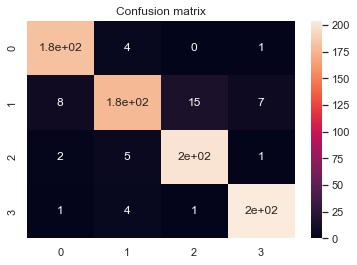

In [121]:
print_report(y_test, y_pred)

- Модель наиболее точно предсказывает auto и job.
- Random forest в отличии от дерева решений показывает низкий recall в категории gorod. То есть статьям, которые относятся к категории gorod, модель предсказывает другие классы.

In [122]:
RandomForest_metrics = compute_metrics('RandomForest', y_test, y_pred)
RandomForest_metrics

{'model': 'RandomForest',
 'accuracy_score': 0.9395807644882861,
 'recall_score': 0.9402894440762604,
 'precision_score': 0.93948992137523,
 'f1_score': 0.9393237121524952}

**Ada Boost**

In [123]:
decision_param = {
    "learning_rate": [0.7, 1],
    "n_estimators": [25, 50]
}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=decision_param, 
                    cv=5, verbose=3, scoring='f1_macro')

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END learning_rate=0.7, n_estimators=25;, score=0.866 total time=   5.8s
[CV 2/5] END learning_rate=0.7, n_estimators=25;, score=0.856 total time=   6.0s
[CV 3/5] END learning_rate=0.7, n_estimators=25;, score=0.848 total time=   6.1s
[CV 4/5] END learning_rate=0.7, n_estimators=25;, score=0.858 total time=   5.9s
[CV 5/5] END learning_rate=0.7, n_estimators=25;, score=0.817 total time=   6.1s
[CV 1/5] END learning_rate=0.7, n_estimators=50;, score=0.871 total time=  11.8s
[CV 2/5] END learning_rate=0.7, n_estimators=50;, score=0.844 total time=  12.0s
[CV 3/5] END learning_rate=0.7, n_estimators=50;, score=0.832 total time=  12.2s
[CV 4/5] END learning_rate=0.7, n_estimators=50;, score=0.860 total time=  12.2s
[CV 5/5] END learning_rate=0.7, n_estimators=50;, score=0.846 total time=  12.0s
[CV 1/5] END ..learning_rate=1, n_estimators=25;, score=0.834 total time=   6.4s
[CV 2/5] END ..learning_rate=1, n_estimators=25;,

In [124]:
ada_params = grid.best_params_
ada_params

{'learning_rate': 1, 'n_estimators': 50}

Accuracy: 0.8766954377311961
Recall: 0.8773550992213334
Precision: 0.8813309900112263
F1: 0.8784479389724161
              precision    recall  f1-score   support

        auto       0.91      0.90      0.91       186
       gorod       0.77      0.86      0.81       207
      health       0.91      0.86      0.88       208
         job       0.93      0.89      0.91       210

    accuracy                           0.88       811
   macro avg       0.88      0.88      0.88       811
weighted avg       0.88      0.88      0.88       811



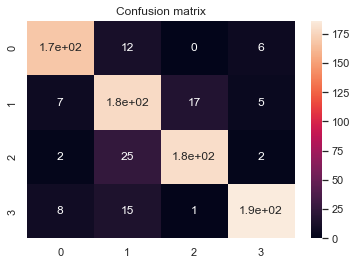

In [125]:
print_report(y_test, y_pred)

- Модель в целом показала средние результаты.
- Низкий precision у категории gorod.

In [126]:
AdaBoost_metrics = compute_metrics('AdaBoost', y_test, y_pred)
AdaBoost_metrics

{'model': 'AdaBoost',
 'accuracy_score': 0.8766954377311961,
 'recall_score': 0.8773550992213334,
 'precision_score': 0.8813309900112263,
 'f1_score': 0.8784479389724161}

**Histogram Gradient Boosting**

In [127]:
classifier = HistGradientBoostingClassifier(learning_rate=0.1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Accuracy: 0.9420468557336621
Recall: 0.942921719565303
Precision: 0.9421936984549535
F1: 0.941943351269541
              precision    recall  f1-score   support

        auto       0.93      0.98      0.95       186
       gorod       0.95      0.88      0.91       207
      health       0.93      0.97      0.95       208
         job       0.97      0.95      0.96       210

    accuracy                           0.94       811
   macro avg       0.94      0.94      0.94       811
weighted avg       0.94      0.94      0.94       811



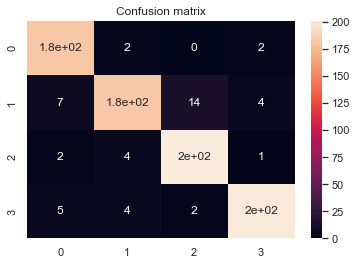

In [128]:
print_report(y_test, y_pred)

- Модель имеет хорошее качество предсказаний.
- Низкий recall для класса gorod по сравнению с другими категориями.

In [129]:
HistGradientBoosting_metrics = compute_metrics('HistGradientBoosting', y_test, y_pred)
HistGradientBoosting_metrics

{'model': 'HistGradientBoosting',
 'accuracy_score': 0.9420468557336621,
 'recall_score': 0.942921719565303,
 'precision_score': 0.9421936984549535,
 'f1_score': 0.941943351269541}

## Результаты

In [130]:
all_metrics = [
    KNN_metrics,
    LogReg_metrics,
    DesicionTree_metrics,
    RandomForest_metrics,
    AdaBoost_metrics,
    HistGradientBoosting_metrics
]

In [131]:
TestModels = pd.DataFrame()
tmp = {}
for model in all_metrics:
    tmp['model'] = model['model']
    tmp['accuracy_score'] = model['accuracy_score']
    tmp['recall_score'] = model['recall_score']
    tmp['precision_score'] = model['precision_score']
    tmp['f1_score'] = model['f1_score']
    TestModels = TestModels.append([tmp])
TestModels.set_index('model', inplace=True)
TestModels

,accuracy_score,recall_score,precision_score,f1_score
model,,,,
KNeighborsClassifier,0.923551,0.924631,0.923681,0.923785
LogisticRegression,0.940814,0.941293,0.941272,0.941211
DecisionTree,0.847102,0.847246,0.852336,0.848536
RandomForest,0.939581,0.940289,0.939490,0.939324
AdaBoost,0.876695,0.877355,0.881331,0.878448
HistGradientBoosting,0.942047,0.942922,0.942194,0.941943


<AxesSubplot:ylabel='model'>

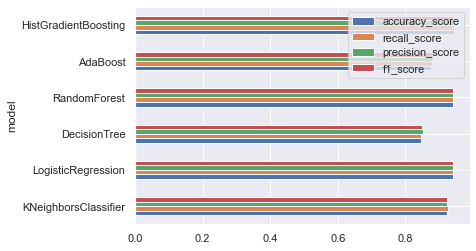

In [132]:
TestModels.plot.barh()

- Самый лучший результат показала модель Hisotgram Gradient Boosting, практически такие же результаты у модели логистической регрессии.
- Самое плохое качество по всем метрикам у модели Decision Tree.

**Вместо стемминга используем лемматизацию из библиотеки Yandex Mystem**

In [32]:
#!pip install pymystem3

In [61]:
from pymystem3 import Mystem
m = Mystem()

In [62]:
prepared_texts = [' '.join(doc) for doc in corpus_tokens]

In [63]:
corpus_tokens_lemmatized = []
for text in log_progress(prepared_texts):
    lemmas = m.lemmatize(text)
    tmp_tokens = ''.join(lemmas)[:-1].split(' ')
    corpus_tokens_lemmatized.append(tmp_tokens)

In [64]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_lemmatized])
print(len(diffs))

4095


**Распределение длин текстов**

<AxesSubplot:ylabel='Count'>

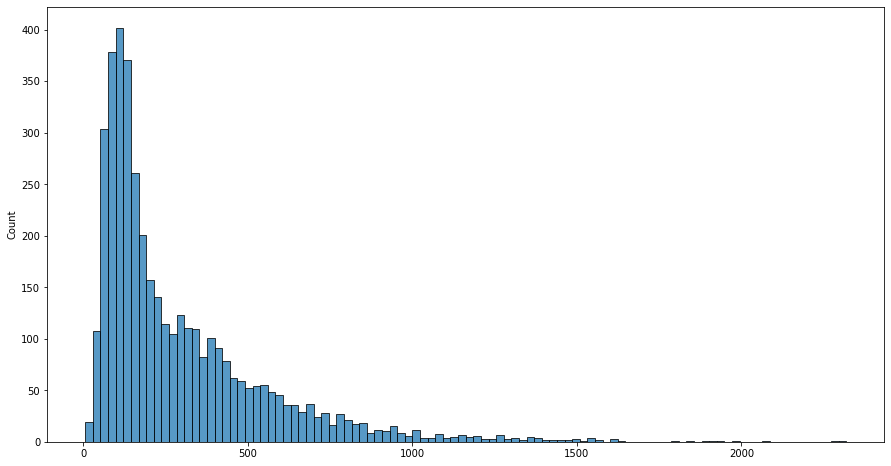

In [65]:
plt.figure(figsize=(15, 8))
sns.histplot(diffs, bins=100)

In [68]:
corpus_tokens_lemmatized1 = np.asarray(corpus_tokens_lemmatized)


C:\Users\antid\AppData\Local\Temp\ipykernel_11372\4281237070.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus_tokens_lemmatized1 = np.asarray(corpus_tokens_lemmatized)


In [79]:
categories1 = np.asarray(categories)

In [133]:
corp4learning = corpus_tokens_lemmatized1[diffs >= 10]
categories4learning = categories1[diffs >= 10]

In [134]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

In [135]:
X = np.asarray([' '.join(words) for words in corp4learning])
y = np.asarray([labels[cat] for cat in categories4learning])

In [136]:
vectorizer = CountVectorizer(max_features=5000, min_df=2, max_df=0.7)
tfidfconverter = TfidfTransformer()

In [137]:
X_trans = vectorizer.fit_transform(X).toarray()
X_trans = tfidfconverter.fit_transform(X_trans).toarray()

In [138]:
X = X_trans

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Воспользуемся двумя лучшими моделями.

**Логистическая регрессия**

In [140]:
classifier = LogisticRegression(solver='lbfgs')

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Accuracy: 0.9157509157509157
Recall: 0.9159695654118991
Precision: 0.9164737095608704
F1: 0.915697139102583
              precision    recall  f1-score   support

        auto       0.98      0.95      0.96       219
       gorod       0.82      0.89      0.85       190
      health       0.92      0.90      0.91       233
         job       0.95      0.93      0.94       177

    accuracy                           0.92       819
   macro avg       0.92      0.92      0.92       819
weighted avg       0.92      0.92      0.92       819



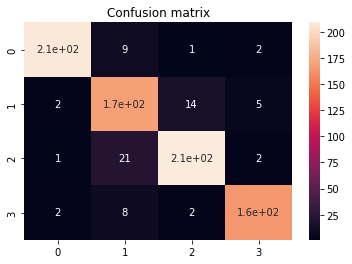

In [141]:
print_report(y_test, y_pred)

**Histogram Gradient Boosting**

In [142]:
classifier = HistGradientBoostingClassifier(learning_rate=0.1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Accuracy: 0.9157509157509157
Recall: 0.9137560637424342
Precision: 0.9161433918979998
F1: 0.9148316645905775
              precision    recall  f1-score   support

        auto       0.94      0.95      0.95       219
       gorod       0.86      0.85      0.85       190
      health       0.91      0.93      0.92       233
         job       0.96      0.93      0.94       177

    accuracy                           0.92       819
   macro avg       0.92      0.91      0.91       819
weighted avg       0.92      0.92      0.92       819



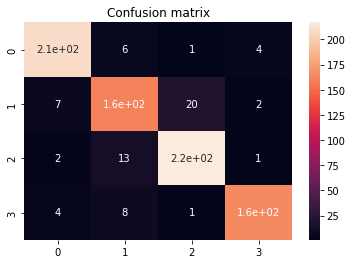

In [143]:
print_report(y_test, y_pred)

Метрики в обеих моделях классификации стали хуже.